Notebook to experiment methodologies for analyzing the outcomes of regression models and experimenting with different diagnostics

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import seaborn as sb
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from statsmodels.compat import lzip
import matplotlib.cm as cm
%matplotlib inline

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
listings = pd.read_csv('Datasources/listings_augmented/listings_augmented_2018-05-23_V5.csv',low_memory=False)

In [3]:
#Dropping the rows identified in featuresExploration notebook:
listings = listings.drop(listings.index[4216:4219])

In [4]:
#Excluded variables from the featuresExploration notebook
%store -r excluded

In [5]:
cols = [i for i in listings.columns if i not in excluded]

In [6]:
X = listings.copy()
X = X[cols]

In [7]:
#temporarily excluding the description text columns
X = X.loc[:,~X.columns.str.contains('description')]

In [8]:
y = listings['price_y'].fillna(listings['price_y'].mean())

In [9]:
y_log = np.log(listings['price_y'].fillna(listings['price_y'].mean()))

Potential transformations on dependent variable: log power, power, etc. 5/22 this is done in featureExploration nb

Potentially use this for imputing price for y: http://scikit-learn.org/stable/modules/label_propagation.html

In [10]:
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
from sklearn.model_selection import KFold,cross_val_score, cross_val_predict, cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import RFE, f_regression, RFECV
from sklearn.ensemble import RandomForestRegressor

In [11]:
X = X[X.columns.drop(X[list(X.filter(regex='Topic'))])]
X = X[X.columns.drop(X[list(X.filter(regex='price'))])]

In [12]:
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.mean())

In [13]:
print np.any(np.isnan(X))
print np.all(np.isfinite(X))

False
True


In [14]:
def scale_data(X):
    return pd.DataFrame(preprocessing.scale(X),columns = X.columns)

In [15]:
def r2_est(X,y):
    linear_regression = linear_model.LinearRegression(normalize=True, fit_intercept=True)
    return r2_score(y, linear_regression.fit(X,y).predict(X))

In [16]:
def r2_sq_est(X,y):
    linear_regression = linear_model.LinearRegression(normalize=True, fit_intercept=True)
    quad = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
    quadratic_predictor = make_pipeline(quad, linear_regression)
    return r2_score(y, quadratic_predictor.fit(X,target).predict(X))

In [17]:
def bivar_reg_linear(X,y):
    R2s = []
    for col in X.columns:
        linear_regression = linear_model.LinearRegression(normalize=True, fit_intercept=True)
        regression_results = linear_regression.fit(X[col].values.reshape(-1, 1),y)
        predictions = cross_val_predict(regression_results, X[col].values.reshape(-1, 1), y, cv=10)
        R2s.append((col, r2_score(y, predictions)))
    return R2s

In [18]:
def bivar_reg_poly(X,y,degree):
    R2s = []
    for col in X.columns:
        
        model = Pipeline([('poly', PolynomialFeatures(degree=degree, interaction_only=False)),('linear', linear_model.LinearRegression(normalize=True,fit_intercept=True))])
        model = model.fit(X[col].values.reshape(-1, 1),y)
        predictions = cross_val_predict(model, X[col].values.reshape(-1, 1), y, cv=10)
        
        R2s.append((col, r2_score(y, predictions)))
        
    return R2s

In [19]:
def linear_reg(X, y):
    
    model = linear_model.LinearRegression(normalize=True, fit_intercept=True)
    scores = cross_validate(model, X, y, cv=10, scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))
    predictions = cross_val_predict(model, X, y, cv=10)
    
    model_results = model.fit(X,y)
    
    r2 = scores['test_r2'].mean()
    mse = -scores['test_neg_mean_squared_error'].mean()
    mae =  -scores['test_neg_mean_absolute_error'].mean()
    rmse =  np.sqrt(-scores['test_neg_mean_absolute_error'].mean())
    
    print 'Test R2 Score: ', r2
    print 'Test MSE Score: ', mse
    print 'Test MAE Score: ', mae
    print 'Test RMSE Score: ', rmse
    
    return model, predictions, model_results, r2, mse, mae, rmse

In [127]:
def linear_reg2(X, y):
    
    model = linear_model.LinearRegression(normalize=True, fit_intercept=True)
    scores = cross_validate(model, X, y, cv=10, scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))
    predictions = cross_val_predict(model, X, y, cv=10)
    model_results = model.fit(X,y)
    
    r2 = scores['test_r2'].mean()
    mse = -scores['test_neg_mean_squared_error'].mean()
    mae =  -scores['test_neg_mean_absolute_error'].mean()
    rmse =  np.sqrt(-scores['test_neg_mean_absolute_error'].mean())
    
    return model, predictions, model_results, r2, mse, mae, rmse

In [20]:
def nonlinear_reg(X,y, degree):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                       ('linear', linear_model.LinearRegression(normalize=True, fit_intercept=True))])
    model = model.fit(X_train, y_train)
    predictions = model.predict(X_test)
       
    r2 = r2_score(predictions, y_test)
    mse = mean_squared_error(predictions, y_test)
    mae =  mean_absolute_error(predictions, y_test)
    rmse =  np.sqrt(mse)
    
    print 'Test R2 Score: ', r2
    print 'Test MSE Score: ', mse
    print 'Test MAE Score: ', mae
    print 'Test RMSE Score: ', rmse
    
    return model, predictions, r2, mse, mae, rmse

In [21]:
def Ridge_reg(X,y,alpha):
    #modify this to use gridsearch cv this weekend: 
    #https://stackoverflow.com/questions/45857274/interpreting-ridge-regression-in-gridsearchcv
    estimator = linear_model.Ridge(alpha=alpha)
    estimator.fit(X, y)
    
    return estimator.predict(X), estimator.coef_

In [22]:
def Lasso_reg(X,y,alpha):
    #modify this to use gridsearch cv this weekend: 
    #https://stackoverflow.com/questions/45857274/interpreting-ridge-regression-in-gridsearchcv
    estimator = linear_model.Lasso(alpha=alpha)
    estimator.fit(X, y)
    
    return estimator.predict(X), estimator.coef_

In [23]:
def Random_Lasso_reg(X,y,alpha):
    #modify this to use gridsearch cv this weekend: 
    #https://stackoverflow.com/questions/45857274/interpreting-ridge-regression-in-gridsearchcv
    estimator = linear_model.RandomizedLasso(alpha=alpha)
    estimator.fit(X, y)
    
    return estimator.scores_

In [24]:
def RFECV_eval(X,y):
    estimator = linear_model.LinearRegression()
    selector = RFECV(estimator, step=1, cv=3)
    selector.fit(X, y)
    return selector.ranking_

In [25]:
def RF_reg(X,y):
    estimator = RandomForestRegressor(max_depth=2, random_state=0)
    estimator.fit(X, y)
    return estimator.predict(X), estimator.feature_importances_

In [26]:
def compute_bivar_r2s(X,y,y_log):
    linear_R2s = bivar_reg_linear(X,y)
    linear_R2s_log = bivar_reg_linear(X,y_log)
    quad_R2s = bivar_reg_poly(X,y,2)
    quad_R2s_log = bivar_reg_poly(X,y_log,2)
    cub_R2s = bivar_reg_poly(X,y,3)
    cub_R2s_log = bivar_reg_poly(X,y_log,3)
    
    idx = [i[0] for i in linear_R2s]
    lin_r2 = [i[1] for i in linear_R2s]
    lin_r2_log = [i[1] for i in linear_R2s_log]
    quad_r2 = [i[1] for i in quad_R2s]
    quad_r2_log = [i[1] for i in quad_R2s_log]
    cub_r2 = [i[1] for i in cub_R2s]
    cub_r2_log = [i[1] for i in cub_R2s_log]

    bivar_r2s = pd.DataFrame({'Feature':idx, 'R2_linear': lin_r2, 'R2_linear_logy':lin_r2_log,
                       'R2_quad':quad_r2, 'R2_quad_logy': quad_r2_log, 'R2_cub':cub_r2, 'R2_cub_logy':cub_r2_log})
    
    return bivar_r2s

In [27]:
X_scaled = scale_data(X)

In [28]:
bivar_r2s = compute_bivar_r2s(X_scaled,y,y_log)
bivar_r2s['mean'] = bivar_r2s.mean(axis=1)

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [29]:
line1 = bivar_r2s['R2_cub'] - bivar_r2s['R2_cub_logy']
line2 = bivar_r2s['R2_quad'] - bivar_r2s['R2_quad_logy']
line3 = bivar_r2s['R2_linear'] - bivar_r2s['R2_linear_logy']

In [30]:
def summarize_differences(bivar_r2s, line, title):    
   
        plt.figure(figsize=(28,15))
        plt.ylabel('Difference')
        plt.legend(loc='upper left', framealpha=0.2, prop={'size':'small'})
        plt.xlabel('Features')
        plt.title(title)
        plt.scatter(bivar_r2s.index, line, alpha=0.7)

        for label, x, y in zip(bivar_r2s.Feature, bivar_r2s.index, line):
            plt.annotate(
                label,
                xy=(x, y), xytext=(-20, 20),
                textcoords='offset points', ha='right', va='bottom',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    
        plt.show()

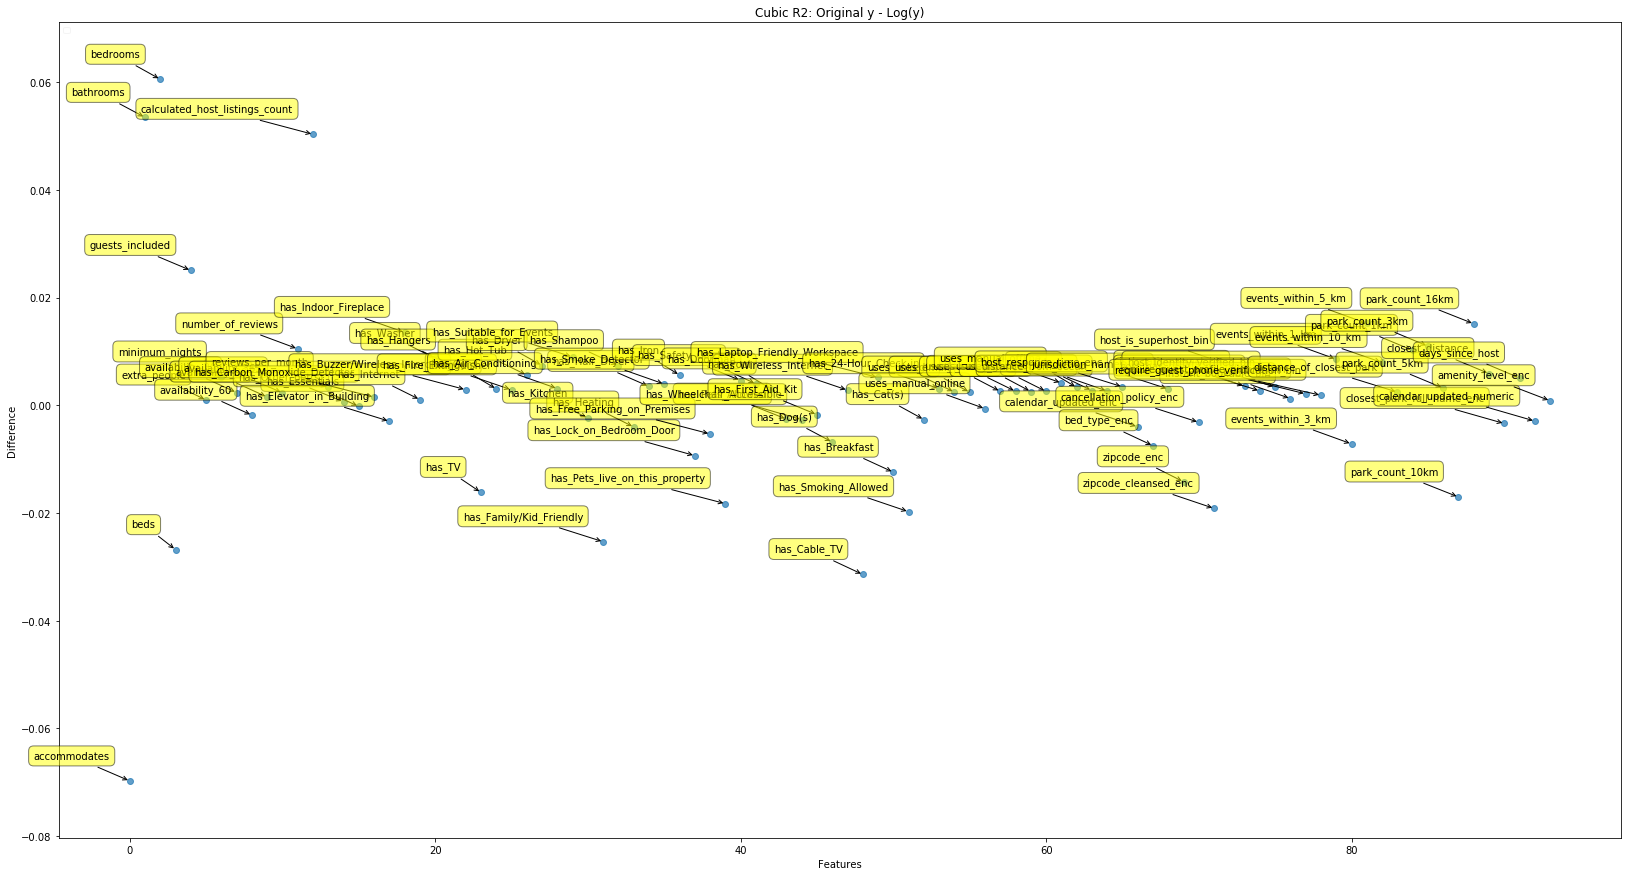

In [31]:
summarize_differences(bivar_r2s, line1, 'Cubic R2: Original y - Log(y)')

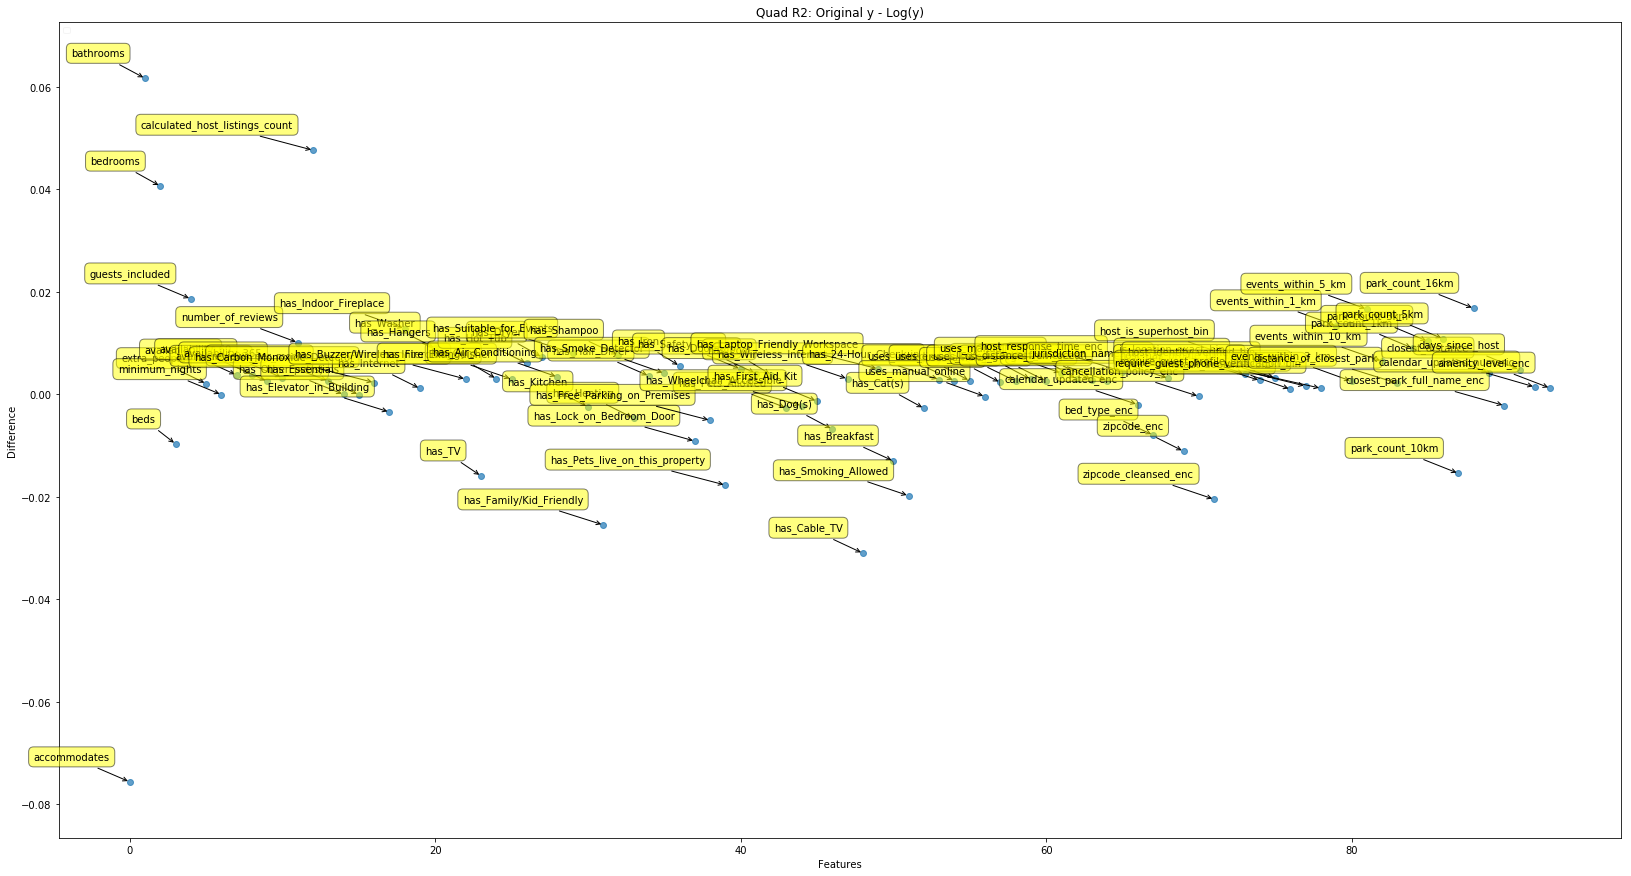

In [32]:
summarize_differences(bivar_r2s, line2, 'Quad R2: Original y - Log(y)')

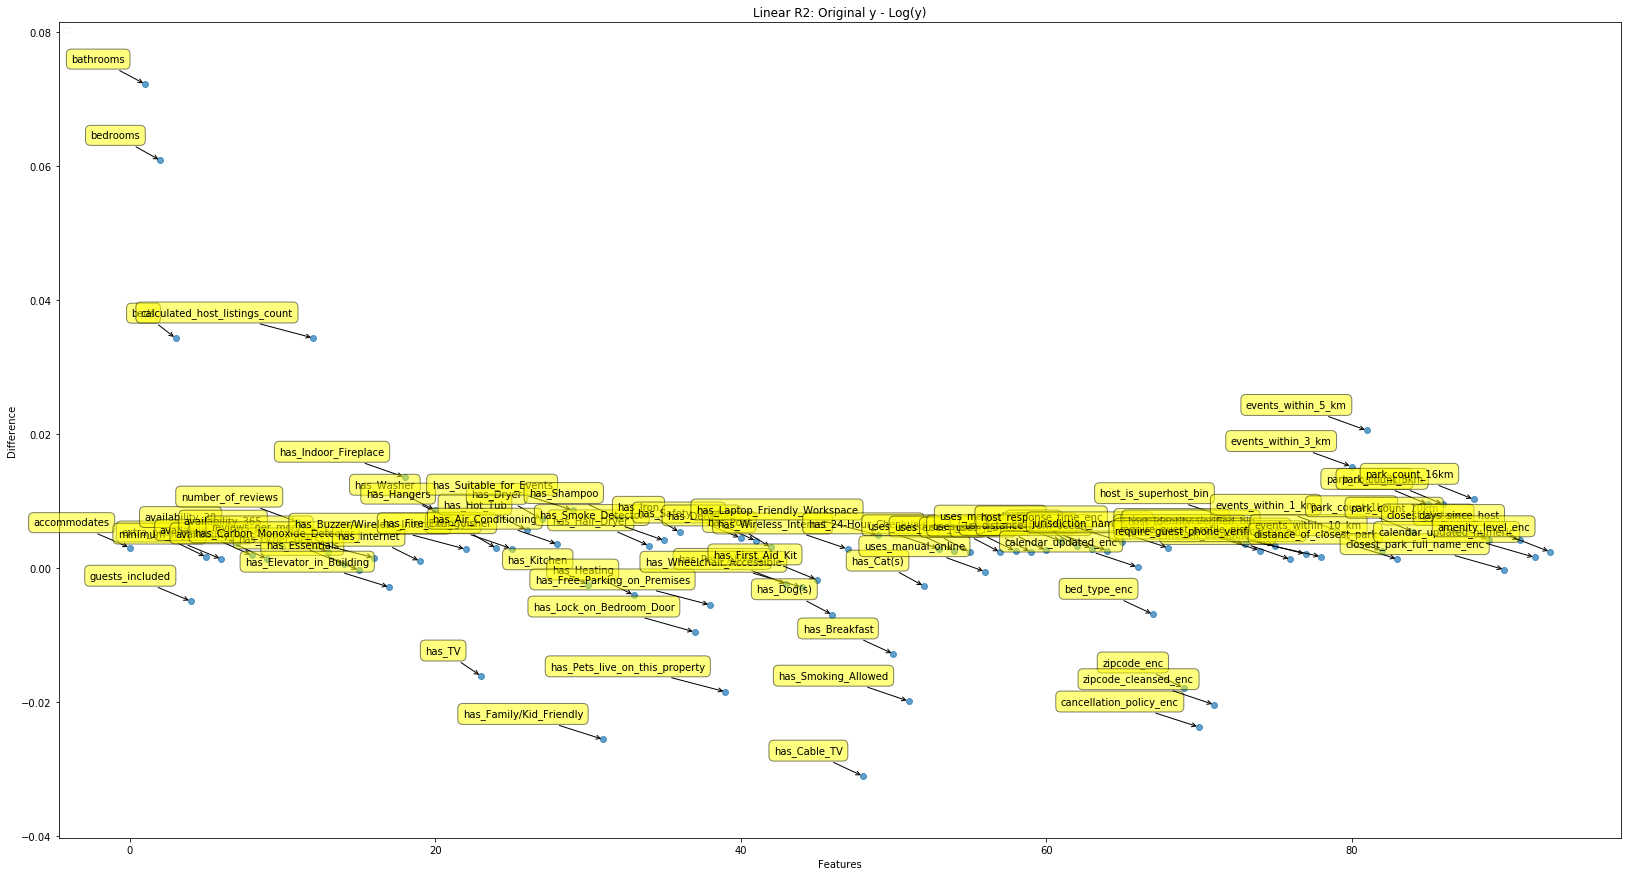

In [33]:
summarize_differences(bivar_r2s, line3, 'Linear R2: Original y - Log(y)')

In [34]:
for i,k in zip([line1, line2, line3],['Cubic Reg R2: Original y - Log(y)','Quad Reg R2: Original y - Log(y)','Linear Reg R2: Original y - Log(y)']):
    print k
    print "Mean: : ", i.mean()
    print "Variance: : ", np.var(i)
    print "----"

Cubic Reg R2: Original y - Log(y)
Mean: :  0.001355016063163056
Variance: :  0.0002242638297086549
----
Quad Reg R2: Original y - Log(y)
Mean: :  0.0016487230163655575
Variance: :  0.00020897541134905513
----
Linear Reg R2: Original y - Log(y)
Mean: :  0.0027087915891486755
Variance: :  0.0001816079590263709
----


Insight: Among bivariate regressions, we generally obtain a higher R2 with original y; however, log(y) gives much better R2 with respect to some key variables (e.g. accommodates)

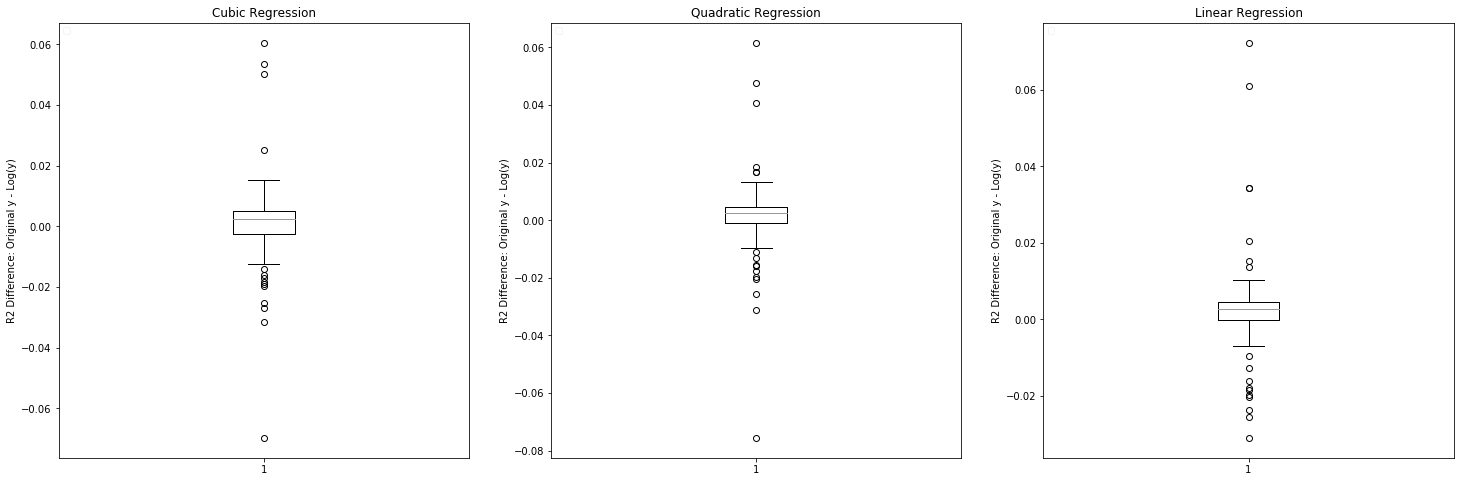

In [35]:
lst = [line1, line2, line3]
titles = ['Cubic Regression','Quadratic Regression','Linear Regression']

fig, axes = plt.subplots(nrows = 1, ncols = 3, sharex = False, sharey= False, figsize = (25,8))

for i,val in enumerate(lst):
    ax = axes[i]
    ax.set_ylabel('R2 Difference: Original y - Log(y)')
    ax.legend(loc='upper left', framealpha=0.2, prop={'size':'small'})
    ax.set_title(titles[i])
    ax.boxplot(val)

In [36]:
#Creating Two Categories of Features: 
#Tier1 will always be in our models and will form our baseline
#Tier2 will be added and removed iteratively during modeling experiments to reach higher R2's
tier1_features = bivar_r2s[bivar_r2s['mean']>0]['Feature']
tier2_features = [i for i in X.columns if i not in tier1_features]

In [37]:
def rank_to_dict(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks ))

In [38]:
def detect_feature_importance(X,y):
    
    names = X.columns
    ranks = {}
    
    model, predictions, model_results, r2, mse, mae, rmse = linear_reg(X, y)
    ranks["Linear_Reg"] = rank_to_dict(np.abs(model.coef_), names)
    
    #model, predictions, model_results, r2, mse, mae, rmse = nonlinear_reg(X, y,2)
    #ranks["Quad_Reg"] = rank_to_dict(np.abs(model.coef_), names)
    
    #model, predictions, model_results, r2, mse, mae, rmse = nonlinear_reg(X, y,3)
    #ranks["Cub_Reg"] = rank_to_dict(np.abs(model.coef_), names)
    
    pred, coef = Ridge_reg(X,y,7)
    ranks["Ridge"] = rank_to_dict(np.abs(coef), names)

    pred, coef = Lasso_reg(X,y,0.05)
    ranks["Lasso"] = rank_to_dict(np.abs(coef), names)

    scores = Random_Lasso_reg(X,y,0.05)
    ranks["Stability"] = rank_to_dict(np.abs(scores), names)

    ranking = RFECV_eval(X,y)
    ranks["RFECV"] = rank_to_dict(map(float, ranking), names, order=-1)

    pred, imp = RF_reg(X,y)
    ranks["RF"] = rank_to_dict(imp, names)

    #f, pval  = f_regression(X, y, center=True)
    #ranks["Corr"] = rank_to_dict(f, names)
    
    return ranks

In [39]:
def detect_interactions(X,y):
    
    #Baseline
    r2_impact = list()
    baseline = r2_est(X,y)
    for j in range(X.shape[1]):
        selection = [i for i in range(X.shape[1]) if i!=j]
        r2_impact.append(((r2_est(X,y)-(r2_est(X.values[:,selection],y)),X.columns[j])))
    
    #Interaction comparison vs Baseline
    create_interactions = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    X_i = create_interactions.fit_transform(X)
    main_effects = create_interactions.n_input_features_
    
    #Now calculating the interactions:
    a = []
    b = []
    inc = []
    
    for k, effect in enumerate(create_interactions.powers_[(main_effects):]):
        A, B = X.columns[effect==1]
        increment = r2_est(X_i[:,list(range(0,main_effects))+[main_effects+k]],y) - baseline
        if increment > 0.01:
            print ("Interaction: var %8s and var %8s R2: %5.3f" %(A,B,increment))
            a.append(A)
            b.append(B)
            inc.append(increment)
    
    increments = pd.DataFrame({
        "Var1":a,
        "Var2":b,
        "Increment": inc
    }, columns = ['Var1','Var2','Increment'])
    
    return increments

In [40]:
def add_interactions(X, increments):
    for i,k in zip(increments.Var1, increments.Var2):
        new_int_feature = str(i) + '*' + str(k)
        X[new_int_feature] = X[i] * X[k]
    return X

In [41]:
def detect_outliers(X):
    
    col_name = []
    outlier_count = []
    outlier_perc = []
    
    clf = LocalOutlierFactor(n_neighbors=20)
    
    for i in X.columns:
        
        pred = clf.fit_predict(X[i].values.reshape(-1,1))
        count = 0
        for i in pred:
            if i<0:
                count=count+1
        
        col_name.append(i)
        outlier_count.append(count)
        outlier_perc.append(count/float(len(X)))

    outliers = pd.DataFrame({
        "col_name":col_name,
        "outlier_count":outlier_count,
        "outlier_perc": outlier_perc
    }, columns = ['Feature_Name','Outlier_Count','Outlier_Perc'])
    
    return outliers

In [42]:
ranks = detect_feature_importance(X_scaled,y)

Test R2 Score:  0.5107558245603097
Test MSE Score:  11948.912474080103
Test MAE Score:  71.21330780538968
Test RMSE Score:  8.438797770144138


/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


In [43]:
ranks_log = detect_feature_importance(X_scaled,y_log)

Test R2 Score:  0.5452873492055599
Test MSE Score:  0.22091876298138674
Test MAE Score:  0.3534089089256646
Test RMSE Score:  0.5944820509701404


/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


In [44]:
feature_importances = pd.DataFrame(ranks, columns = ranks.keys())
feature_importances_log = pd.DataFrame(ranks_log, columns = ranks_log.keys())

In [45]:
feature_importances['mean'] = feature_importances.mean(axis=1)
feature_importances_log['mean'] = feature_importances_log.mean(axis=1)

In [46]:
#Now we create our baseline models: 
#we try one baseline model with features that had positive R2 in bivariate regressoions
#we try a second bline model with top 20 features in terms of feature importance (calculated by mean of importance methods)

In [47]:
model, predictions, model_results, r2, mse, mae, rmse = linear_reg(X_scaled[tier1_features],y)

Test R2 Score:  0.46947060829031717
Test MSE Score:  12751.52020945919
Test MAE Score:  74.72146438691246
Test RMSE Score:  8.644157818255776


In [48]:
model, predictions, model_results, r2, mse, mae, rmse = linear_reg(X_scaled[tier1_features],y_log)

Test R2 Score:  0.45209714264535644
Test MSE Score:  0.27168986973788495
Test MAE Score:  0.39589604342094975
Test RMSE Score:  0.6292027045562898


In [49]:
model, predictions, r2, mse, mae, rmse = nonlinear_reg(X_scaled[tier1_features],y,2)

Test R2 Score:  0.2774770845932121
Test MSE Score:  19949.939834597073
Test MAE Score:  79.884447637063
Test RMSE Score:  141.24425593487712


In [50]:
model, predictions, r2, mse, mae, rmse = nonlinear_reg(X_scaled[tier1_features],y_log,2)

Test R2 Score:  0.4190033514779268
Test MSE Score:  0.3002847514027727
Test MAE Score:  0.371924478909555
Test RMSE Score:  0.5479824371298525


In [51]:
#Top 20 features by feature importances

In [52]:
top20_features = [i for i in feature_importances.sort_values(by='mean', ascending=False).head(20).index]
top20_features_ylog = [i for i in feature_importances_log.sort_values(by='mean', ascending=False).head(20).index]

In [53]:
model, predictions, model_results, r2, mse, mae, rmse = linear_reg(X_scaled[top20_features],y)

Test R2 Score:  0.5272429348962797
Test MSE Score:  11488.673615095217
Test MAE Score:  69.65671883016492
Test RMSE Score:  8.346060078274354


In [54]:
model, predictions, model_results, r2, mse, mae, rmse = linear_reg(X_scaled[top20_features],y_log)

Test R2 Score:  0.5335785791809247
Test MSE Score:  0.22682020010950205
Test MAE Score:  0.35649064499179145
Test RMSE Score:  0.5970683754745276


In [55]:
model, predictions, r2, mse, mae, rmse = nonlinear_reg(X_scaled[top20_features_ylog],y,2)

Test R2 Score:  -0.0008214774940726866
Test MSE Score:  1.8021526079254572e+25
Test MAE Score:  578976241289.3833
Test RMSE Score:  4245176801884.0596


In [56]:
model, predictions, r2, mse, mae, rmse = nonlinear_reg(X_scaled[top20_features_ylog],y_log,2)

Test R2 Score:  -0.0008214777250070693
Test MSE Score:  9.431554036754539e+20
Test MAE Score:  4188481372.190218
Test RMSE Score:  30710835281.305096


In [57]:
# Now visualize these outcomes
#create viz method that calls all viz methods relevant

Insight: seems like using the top 20 features found with original y and using linear regression might be the better approach. NB this doesn't mean we should rule out using logy as dependedn variable, but tht the feature selection method has been doing better with y rather than y log'

Insight: using the top n features from feature selection methods seems to be much better than just looking at top bivariate r2s

Next: we use a higher n for top n features and try some more baseline models to see how things change

In [58]:
top30_features = [i for i in feature_importances.sort_values(by='mean', ascending=False).head(30).index]
top35_features = [i for i in feature_importances.sort_values(by='mean', ascending=False).head(35).index]
top40_features = [i for i in feature_importances.sort_values(by='mean', ascending=False).head(40).index]
top45_features = [i for i in feature_importances.sort_values(by='mean', ascending=False).head(45).index]

In [59]:
for i in [top30_features,top35_features,top40_features,top45_features]:
    print "Model for Top %f Features: " %(int(len(i)))
    model, predictions, model_results, r2, mse, mae, rmse = linear_reg(X_scaled[i],y)
    print "----"
    print ""

Model for Top 30.000000 Features: 
Test R2 Score:  0.5280736625588084
Test MSE Score:  11490.203928252595
Test MAE Score:  69.30048321351292
Test RMSE Score:  8.32469117826679
----

Model for Top 35.000000 Features: 
Test R2 Score:  0.5282965072310184
Test MSE Score:  11483.691711547785
Test MAE Score:  69.47277873436082
Test RMSE Score:  8.335033217351976
----

Model for Top 40.000000 Features: 
Test R2 Score:  0.5272757801752066
Test MSE Score:  11539.773851893558
Test MAE Score:  69.74070766758692
Test RMSE Score:  8.351090208325314
----

Model for Top 45.000000 Features: 
Test R2 Score:  0.5267940072992268
Test MSE Score:  11561.96968752853
Test MAE Score:  69.74613779902926
Test RMSE Score:  8.351415317120162
----



In [60]:
for i in [top30_features,top35_features,top40_features,top45_features]:
    print "Model for Top %f Features: " %(int(len(i)))
    model, predictions, model_results, r2, mse, mae, rmse = linear_reg(X_scaled[i],y_log)
    print "----"
    print ""

Model for Top 30.000000 Features: 
Test R2 Score:  0.5537325116568452
Test MSE Score:  0.21754014956765516
Test MAE Score:  0.3506985641232762
Test RMSE Score:  0.5921980784528739
----

Model for Top 35.000000 Features: 
Test R2 Score:  0.5538265406444056
Test MSE Score:  0.21740260651139126
Test MAE Score:  0.35122342053899513
Test RMSE Score:  0.5926410553944058
----

Model for Top 40.000000 Features: 
Test R2 Score:  0.5532919523732641
Test MSE Score:  0.217135970393183
Test MAE Score:  0.35145013535310493
Test RMSE Score:  0.5928322995191009
----

Model for Top 45.000000 Features: 
Test R2 Score:  0.5555589674343333
Test MSE Score:  0.21608419625373973
Test MAE Score:  0.34935812251170006
Test RMSE Score:  0.5910652438705054
----



Insight: we have had some small increases in R2 but this is not enough. We can try the following: 1) select the best features with a different methodology (we will try Linear_Reg coefficients and RFECV) 2) compute interaction variables and add them to X. 3) try a different modeling technique (this can be done with reg scalability notebook) 4) simply add more features

In [61]:
top20_RFECV = [i for i in feature_importances.sort_values(by='RFECV', ascending=False).head(20).index]
top25_RFECV = [i for i in feature_importances.sort_values(by='RFECV', ascending=False).head(25).index]
top30_RFECV = [i for i in feature_importances.sort_values(by='RFECV', ascending=False).head(30).index]
top35_RFECV = [i for i in feature_importances.sort_values(by='RFECV', ascending=False).head(35).index]
top40_RFECV = [i for i in feature_importances.sort_values(by='RFECV', ascending=False).head(40).index]
top45_RFECV = [i for i in feature_importances.sort_values(by='RFECV', ascending=False).head(45).index]

In [62]:
for i in [top20_RFECV,top25_RFECV,top30_RFECV,top35_RFECV, top40_RFECV, top45_RFECV]:
    print "Model for Top %f Features: " %(int(len(i)))
    model, predictions, model_results, r2, mse, mae, rmse = linear_reg(X_scaled[i],y)
    print "----"
    print ""

Model for Top 20.000000 Features: 
Test R2 Score:  0.4790042114596168
Test MSE Score:  12375.649338226274
Test MAE Score:  74.19772638402061
Test RMSE Score:  8.613810212909303
----

Model for Top 25.000000 Features: 
Test R2 Score:  0.49873730277667605
Test MSE Score:  11925.050638921814
Test MAE Score:  72.25452301265545
Test RMSE Score:  8.500266055404117
----

Model for Top 30.000000 Features: 
Test R2 Score:  0.5016881854710046
Test MSE Score:  11880.230267092014
Test MAE Score:  72.08686408874242
Test RMSE Score:  8.490398346882342
----

Model for Top 35.000000 Features: 
Test R2 Score:  0.5173581111208421
Test MSE Score:  11765.10400914784
Test MAE Score:  70.14393150310319
Test RMSE Score:  8.375197400843946
----

Model for Top 40.000000 Features: 
Test R2 Score:  0.5282786970787665
Test MSE Score:  11522.273995280213
Test MAE Score:  69.55197862674622
Test RMSE Score:  8.339782888465756
----

Model for Top 45.000000 Features: 
Test R2 Score:  0.5270317849253109
Test MSE Score:

In [63]:
for i in [top20_RFECV,top25_RFECV,top30_RFECV,top35_RFECV, top40_RFECV, top45_RFECV]:
    print "Model for Top %f Features: " %(int(len(i)))
    model, predictions, model_results, r2, mse, mae, rmse = linear_reg(X_scaled[i],y_log)
    print "----"
    print ""

Model for Top 20.000000 Features: 
Test R2 Score:  0.5073635015332698
Test MSE Score:  0.240849987159541
Test MAE Score:  0.37454776627527114
Test RMSE Score:  0.612003077014545
----

Model for Top 25.000000 Features: 
Test R2 Score:  0.5355060754451039
Test MSE Score:  0.22680310256045297
Test MAE Score:  0.35848288028422487
Test RMSE Score:  0.5987343987814838
----

Model for Top 30.000000 Features: 
Test R2 Score:  0.5365509460251133
Test MSE Score:  0.2261060247040731
Test MAE Score:  0.3584391172909064
Test RMSE Score:  0.5986978514166443
----

Model for Top 35.000000 Features: 
Test R2 Score:  0.5416202775585538
Test MSE Score:  0.22342483888509856
Test MAE Score:  0.35279886160190377
Test RMSE Score:  0.5939687378994822
----

Model for Top 40.000000 Features: 
Test R2 Score:  0.5587208851687528
Test MSE Score:  0.21469796206991912
Test MAE Score:  0.3477866435683001
Test RMSE Score:  0.5897343839121982
----

Model for Top 45.000000 Features: 
Test R2 Score:  0.5578673293102343
T

Let's try the top features selected by linear regression coefficients

In [64]:
top20_Linear_Reg = [i for i in feature_importances.sort_values(by='Linear_Reg', ascending=False).head(20).index]
top25_Linear_Reg = [i for i in feature_importances.sort_values(by='Linear_Reg', ascending=False).head(25).index]
top30_Linear_Reg = [i for i in feature_importances.sort_values(by='Linear_Reg', ascending=False).head(30).index]
top35_Linear_Reg = [i for i in feature_importances.sort_values(by='Linear_Reg', ascending=False).head(35).index]
top40_Linear_Reg = [i for i in feature_importances.sort_values(by='Linear_Reg', ascending=False).head(40).index]
top45_Linear_Reg = [i for i in feature_importances.sort_values(by='Linear_Reg', ascending=False).head(45).index]

In [65]:
for i in [top20_Linear_Reg,top25_Linear_Reg,top30_Linear_Reg,top35_Linear_Reg, top40_Linear_Reg, top45_Linear_Reg]:
    print "Model for Top %f Features: " %(int(len(i)))
    model, predictions, model_results, r2, mse, mae, rmse = linear_reg(X_scaled[i],y)
    print "----"
    print ""

Model for Top 20.000000 Features: 
Test R2 Score:  0.516286534966709
Test MSE Score:  11691.520576675053
Test MAE Score:  70.56333798824383
Test RMSE Score:  8.400198687426615
----

Model for Top 25.000000 Features: 
Test R2 Score:  0.5262212113847722
Test MSE Score:  11483.328302618098
Test MAE Score:  69.88792170086762
Test RMSE Score:  8.359899622655025
----

Model for Top 30.000000 Features: 
Test R2 Score:  0.5272842881112835
Test MSE Score:  11433.849681724347
Test MAE Score:  69.88094389694915
Test RMSE Score:  8.359482274456305
----

Model for Top 35.000000 Features: 
Test R2 Score:  0.5303774026146799
Test MSE Score:  11323.341627046
Test MAE Score:  69.73448343382339
Test RMSE Score:  8.350717540057465
----

Model for Top 40.000000 Features: 
Test R2 Score:  0.5272373409287189
Test MSE Score:  11541.33108334903
Test MAE Score:  69.72465789571626
Test RMSE Score:  8.35012921431257
----

Model for Top 45.000000 Features: 
Test R2 Score:  0.5279252955299578
Test MSE Score:  1152

In [66]:
for i in [top20_Linear_Reg,top25_Linear_Reg,top30_Linear_Reg,top35_Linear_Reg, top40_Linear_Reg, top45_Linear_Reg]:
    print "Model for Top %f Features: " %(int(len(i)))
    model, predictions, model_results, r2, mse, mae, rmse = linear_reg(X_scaled[i],y_log)
    print "----"
    print ""

Model for Top 20.000000 Features: 
Test R2 Score:  0.5036480270931156
Test MSE Score:  0.24148723335230743
Test MAE Score:  0.3696854895631313
Test RMSE Score:  0.6080176720812737
----

Model for Top 25.000000 Features: 
Test R2 Score:  0.5336150518968013
Test MSE Score:  0.22630150824575268
Test MAE Score:  0.35666997151126845
Test RMSE Score:  0.5972185291091264
----

Model for Top 30.000000 Features: 
Test R2 Score:  0.5350583563029939
Test MSE Score:  0.22567619442022013
Test MAE Score:  0.3566329421682931
Test RMSE Score:  0.597187526802338
----

Model for Top 35.000000 Features: 
Test R2 Score:  0.5533550409763687
Test MSE Score:  0.21758964402614556
Test MAE Score:  0.35121874962567934
Test RMSE Score:  0.5926371146204727
----

Model for Top 40.000000 Features: 
Test R2 Score:  0.5536203755274144
Test MSE Score:  0.21703848654408162
Test MAE Score:  0.34998827368919005
Test RMSE Score:  0.5915980676854768
----

Model for Top 45.000000 Features: 
Test R2 Score:  0.557219384656737

Insight: the better results seem to be coming with y_log and simply by increasing the number of variables. We will try adding interaction variables next

In [67]:
#With all features
print 'Increments for original y'
increments = detect_interactions(X_scaled,y)
print '------'
print 'Increments for log y'
increments_log = detect_interactions(X_scaled,y_log)

Increments for original y
Interaction: var accommodates and var bathrooms R2: 0.017
Interaction: var accommodates and var bedrooms R2: 0.014
Interaction: var bathrooms and var bedrooms R2: 0.020
Interaction: var bathrooms and var     beds R2: 0.011
Interaction: var bathrooms and var calculated_host_listings_count R2: 0.015
Interaction: var bathrooms and var  has_Gym R2: 0.010
Interaction: var bathrooms and var cancellation_policy_enc R2: 0.010
------
Increments for log y
Interaction: var accommodates and var bathrooms R2: 0.029
Interaction: var accommodates and var bedrooms R2: 0.031
Interaction: var accommodates and var     beds R2: 0.027
Interaction: var bathrooms and var bedrooms R2: 0.022
Interaction: var bathrooms and var     beds R2: 0.016
Interaction: var bathrooms and var calculated_host_listings_count R2: 0.010
Interaction: var bathrooms and var cancellation_policy_enc R2: 0.011
Interaction: var bedrooms and var     beds R2: 0.014
Interaction: var calculated_host_listings_coun

In [68]:
#only with features found to be important in latest model runs
print 'Increments for original y'
increments = detect_interactions(X_scaled[top45_Linear_Reg],y)
print '------'
print 'Increments for log y'
increments_log = detect_interactions(X_scaled[top45_Linear_Reg],y_log)

Increments for original y
Interaction: var accommodates and var bedrooms R2: 0.014
Interaction: var accommodates and var bathrooms R2: 0.017
Interaction: var bedrooms and var bathrooms R2: 0.020
Interaction: var calculated_host_listings_count and var bathrooms R2: 0.014
Interaction: var     beds and var bathrooms R2: 0.011
------
Increments for log y
Interaction: var accommodates and var bedrooms R2: 0.032
Interaction: var accommodates and var     beds R2: 0.028
Interaction: var accommodates and var bathrooms R2: 0.030
Interaction: var bedrooms and var     beds R2: 0.014
Interaction: var bedrooms and var bathrooms R2: 0.022
Interaction: var calculated_host_listings_count and var has_Suitable_for_Events R2: 0.013
Interaction: var calculated_host_listings_count and var bathrooms R2: 0.010
Interaction: var calculated_host_listings_count and var has_Breakfast R2: 0.010
Interaction: var     beds and var bathrooms R2: 0.016
Interaction: var bathrooms and var cancellation_policy_enc R2: 0.011

In [69]:
X_inters = add_interactions(X, increments)
X_inters_log = add_interactions(X, increments_log)

In [70]:
cols = [i for i in X_inters.filter(regex='\*').columns] + top45_Linear_Reg
cols_log = [i for i in X_inters_log.filter(regex='\*').columns] + top45_Linear_Reg

In [71]:
model, predictions, model_results, r2, mse, mae, rmse = linear_reg(X_inters[cols],y)

Test R2 Score:  0.5436426856560808
Test MSE Score:  10892.47250417561
Test MAE Score:  69.1049400544038
Test RMSE Score:  8.31293811202777


In [72]:
model, predictions, model_results, r2, mse, mae, rmse = linear_reg(X_inters_log[cols_log],y_log)

Test R2 Score:  0.6405778591278658
Test MSE Score:  0.175626636083892
Test MAE Score:  0.31861561546203065
Test RMSE Score:  0.5644604640380322


Insight: we saw a big jump in R2 (with y_log) when we added interactions! (Also tried quadratic model but ran forever). Let's try to understand the jump in R2 with visualizations:

In [73]:
model_1, predictions_1, model_results_1, r2_1, mse_1, mae_1, rmse_1 = linear_reg(X_scaled[top45_Linear_Reg],y_log)

Test R2 Score:  0.5572193846567371
Test MSE Score:  0.21539775103654007
Test MAE Score:  0.3484378533557932
Test RMSE Score:  0.5902862469648037


In [74]:
model_2, predictions_2, model_results_2, r2_2, mse_2, mae_2, rmse_2 = linear_reg(X_inters_log[cols_log],y_log)

Test R2 Score:  0.6405778591278658
Test MSE Score:  0.175626636083892
Test MAE Score:  0.31861561546203065
Test RMSE Score:  0.5644604640380322


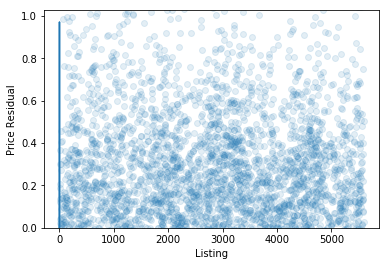

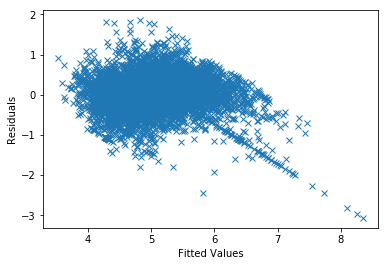

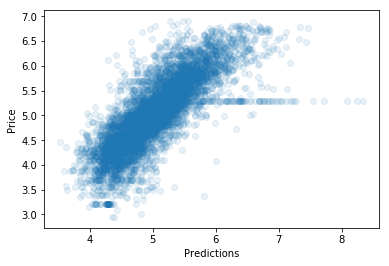

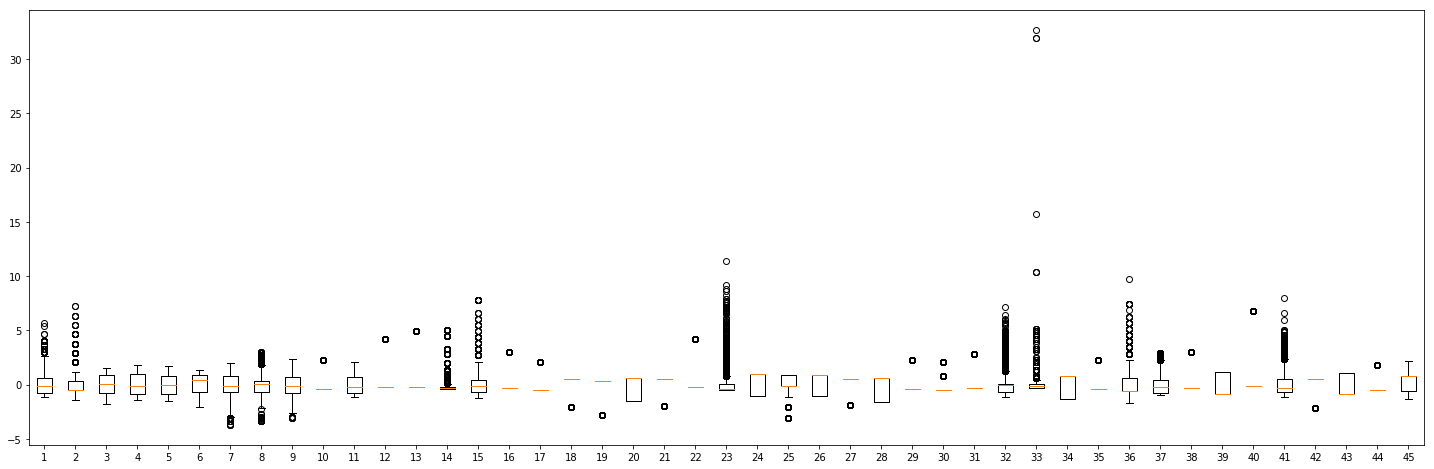

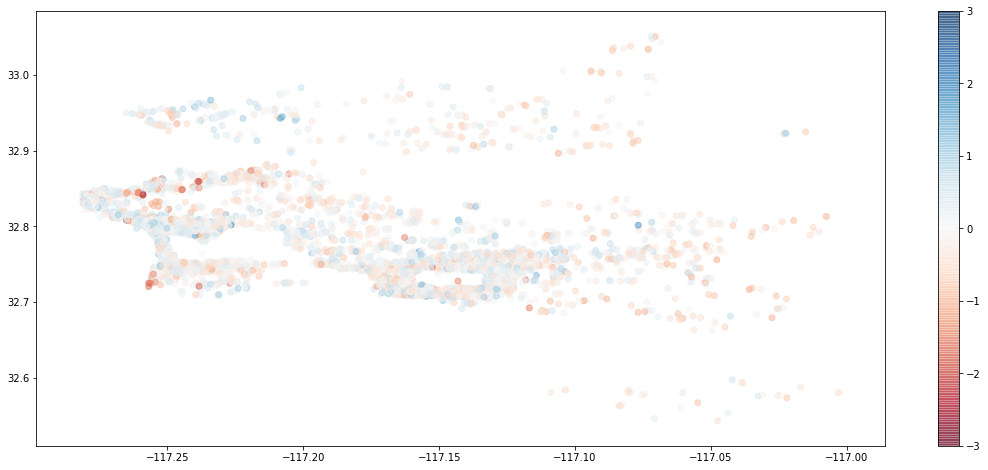

In [95]:
make_visualizations(X_scaled[top45_Linear_Reg],y_log,predictions_1,model_results_1)

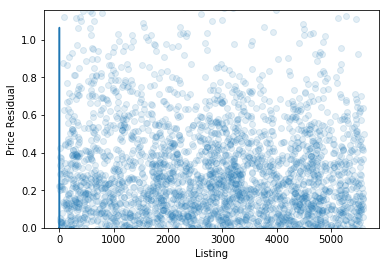

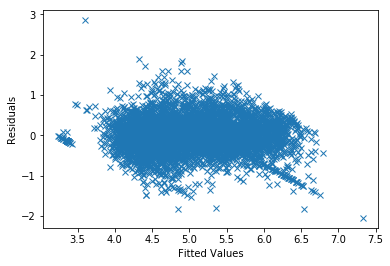

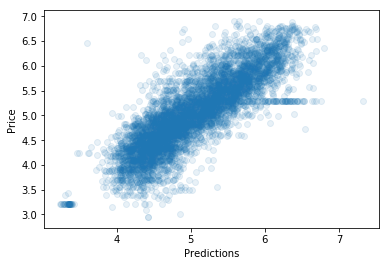

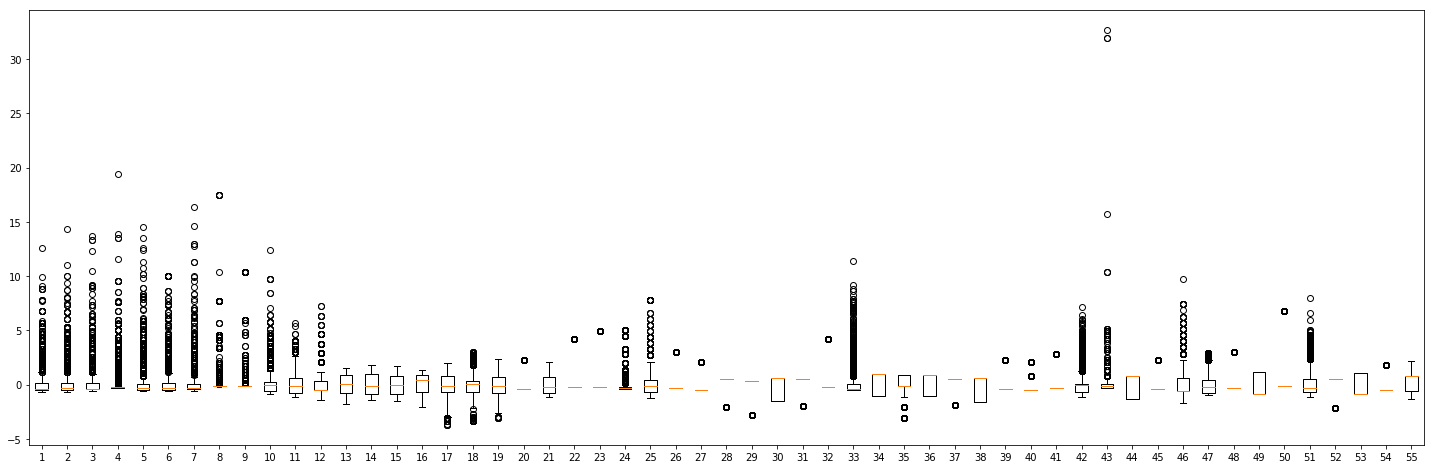

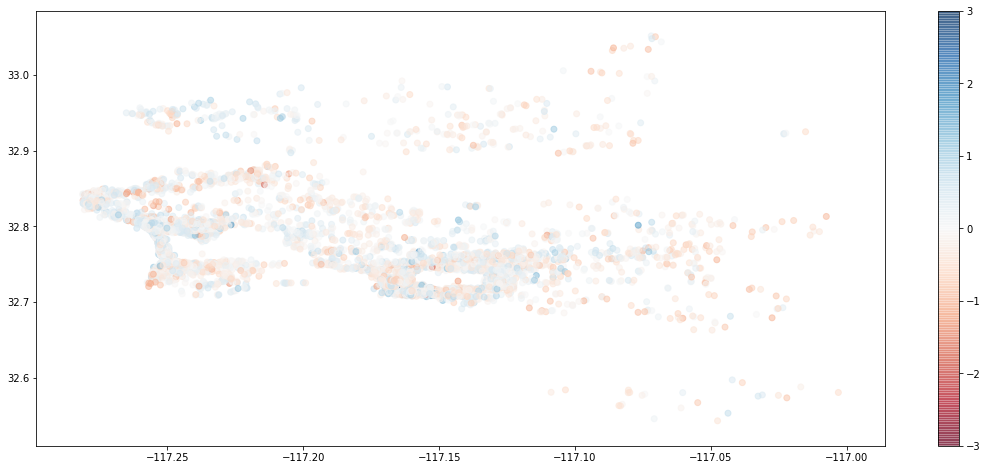

In [96]:
make_visualizations(X_inters_log[cols_log],y_log,predictions_2,model_results_2)

In [ ]:
#Try adding more variables and then redoing interactions
#plot how r2 and other scores vary as number of variables varies
#plot how bias varies as other scores vary and/or number of variables varies
#use regressionScalability to test backstep method

In [101]:
top50_Linear_Reg = [i for i in feature_importances.sort_values(by='Linear_Reg', ascending=False).head(50).index]
top55_Linear_Reg = [i for i in feature_importances.sort_values(by='Linear_Reg', ascending=False).head(55).index]
top60_Linear_Reg = [i for i in feature_importances.sort_values(by='Linear_Reg', ascending=False).head(60).index]
top65_Linear_Reg = [i for i in feature_importances.sort_values(by='Linear_Reg', ascending=False).head(65).index]
top70_Linear_Reg = [i for i in feature_importances.sort_values(by='Linear_Reg', ascending=False).head(70).index]
top75_Linear_Reg = [i for i in feature_importances.sort_values(by='Linear_Reg', ascending=False).head(75).index]
top80_Linear_Reg = [i for i in feature_importances.sort_values(by='Linear_Reg', ascending=False).head(80).index]
top85_Linear_Reg = [i for i in feature_importances.sort_values(by='Linear_Reg', ascending=False).head(85).index]
top90_Linear_Reg = [i for i in feature_importances.sort_values(by='Linear_Reg', ascending=False).head(90).index]

In [99]:
for i in [top50_Linear_Reg,top55_Linear_Reg,top60_Linear_Reg,top65_Linear_Reg, top70_Linear_Reg, top75_Linear_Reg]:
    print "Model for Top %f Features: " %(int(len(i)))
    model, predictions, model_results, r2, mse, mae, rmse = linear_reg(X_scaled[i],y)
    print "----"
    print ""

Model for Top 50.000000 Features: 
Test R2 Score:  0.5250910508854276
Test MSE Score:  11591.880466639706
Test MAE Score:  69.81388264346069
Test RMSE Score:  8.355470222761893
----

Model for Top 55.000000 Features: 
Test R2 Score:  0.5237973547866857
Test MSE Score:  11619.748490959997
Test MAE Score:  70.05825298357867
Test RMSE Score:  8.370080823001572
----

Model for Top 60.000000 Features: 
Test R2 Score:  0.5225992966746251
Test MSE Score:  11657.135632510599
Test MAE Score:  70.25782218145073
Test RMSE Score:  8.381993926354918
----

Model for Top 65.000000 Features: 
Test R2 Score:  0.5218014156649222
Test MSE Score:  11679.665775057787
Test MAE Score:  70.29461248598423
Test RMSE Score:  8.384188242518427
----

Model for Top 70.000000 Features: 
Test R2 Score:  0.5192695336830505
Test MSE Score:  11752.510792593945
Test MAE Score:  70.47928485821022
Test RMSE Score:  8.395194152502384
----

Model for Top 75.000000 Features: 
Test R2 Score:  0.5178318069150567
Test MSE Score:

Insight: without interactions, it looks like increasing the  number of variables does not increase the R2 beyond 65-70 features. Let's now visualize this

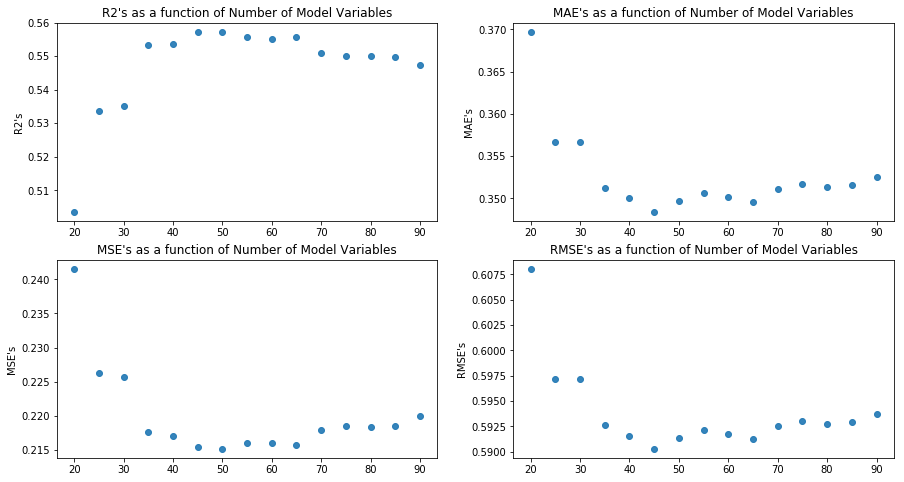

In [165]:
r2s = []
maes = []
mses = []
rmses = []
for i in [top20_Linear_Reg,top25_Linear_Reg,top30_Linear_Reg,top35_Linear_Reg, top40_Linear_Reg, top45_Linear_Reg,
          top50_Linear_Reg,top55_Linear_Reg,top60_Linear_Reg,top65_Linear_Reg, top70_Linear_Reg, top75_Linear_Reg,
          top80_Linear_Reg,top85_Linear_Reg,top90_Linear_Reg]:
    model, predictions, model_results, r2, mse, mae, rmse = linear_reg2(X_scaled[i],y_log);
    r2s.append(r2)
    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)

lst = [r2s, maes, mses, rmses]
titles = ['R2\'s', 'MAE\'s', 'MSE\'s', 'RMSE\'s']
    
fig, axes = plt.subplots(nrows = 2, ncols = 2, sharex = False, sharey= False, figsize = (15,8))
axes_list = [item for sublist in axes for item in sublist] 
    
for i,val in enumerate(lst):
    ax = axes_list.pop(0)
    ax.plot([k for k in range(20,95,5)], val, 'o', alpha=0.9)
    ax.set_title('%s as a function of Number of Model Variables'%(titles[i]))
    ax.set_ylabel('%s'%(titles[i]))

for ax in axes_list:
    ax.remove()

In [ ]:
#Derive insights by comparing the different error methods -- if MSE increases but MAE decreses, this means...

Insight: Highest R2's are derived with top 45 - 65 features; now let's add interactions for each of the 4 cases

In [190]:
len(increments_log_45)

10

In [191]:
len(increments_log_50)

8

In [188]:
len(X_inters_log_55.columns)

104

In [189]:
len(X_inters_log_60.columns)

104

In [167]:
print 'Increments for log y - Top 45 Features'
increments_log_45 = detect_interactions(X_scaled[top45_Linear_Reg],y_log)
print '------'
print 'Increments for log y - Top 50 Features'
increments_log_50 = detect_interactions(X_scaled[top50_Linear_Reg],y_log)
print '------'
print 'Increments for log y - Top 55 Features'
increments_log_55 = detect_interactions(X_scaled[top55_Linear_Reg],y_log)
print '------'
print 'Increments for log y - Top 60 Features'
increments_log_60 = detect_interactions(X_scaled[top60_Linear_Reg],y_log)
print '------'
print 'Increments for log y - Top 65 Features'
increments_log_65 = detect_interactions(X_scaled[top65_Linear_Reg],y_log)

Increments for log y - Top 45 Features
Interaction: var accommodates and var bedrooms R2: 0.032
Interaction: var accommodates and var     beds R2: 0.028
Interaction: var accommodates and var bathrooms R2: 0.030
Interaction: var bedrooms and var     beds R2: 0.014
Interaction: var bedrooms and var bathrooms R2: 0.022
Interaction: var calculated_host_listings_count and var has_Suitable_for_Events R2: 0.013
Interaction: var calculated_host_listings_count and var bathrooms R2: 0.010
Interaction: var calculated_host_listings_count and var has_Breakfast R2: 0.010
Interaction: var     beds and var bathrooms R2: 0.016
Interaction: var bathrooms and var cancellation_policy_enc R2: 0.011
------
Increments for log y - Top 50 Features
Interaction: var accommodates and var bedrooms R2: 0.032
Interaction: var accommodates and var     beds R2: 0.028
Interaction: var accommodates and var bathrooms R2: 0.030
Interaction: var bedrooms and var     beds R2: 0.015
Interaction: var bedrooms and var bathroom

In [192]:
X_inters_log_45 = add_interactions(X_scaled, increments_log_45)
X_inters_log_50 = add_interactions(X_scaled, increments_log_50)
X_inters_log_55 = add_interactions(X_scaled, increments_log_55)
X_inters_log_60 = add_interactions(X_scaled, increments_log_60)
X_inters_log_65 = add_interactions(X_scaled, increments_log_65)

In [193]:
n = [k for k in range(45,70,5)]
r2s, mses, maes = [], [], []
for n,i in zip(n,[X_inters_log_45,X_inters_log_50,X_inters_log_55,X_inters_log_60, X_inters_log_65]):
    #print "Model for Top %f Features: " %(n)
    model, predictions, model_results, r2, mse, mae, rmse = linear_reg(i,y)
    r2s.append(r2)
    mses.append(mse)
    maes.append(mae)
    print "----"
    print ""

Test R2 Score:  0.5306862106173356
Test MSE Score:  11186.439567233107
Test MAE Score:  70.35745556207809
Test RMSE Score:  8.387935119090876
----

Test R2 Score:  0.5306862106173356
Test MSE Score:  11186.439567233107
Test MAE Score:  70.35745556207809
Test RMSE Score:  8.387935119090876
----

Test R2 Score:  0.5306862106173356
Test MSE Score:  11186.439567233107
Test MAE Score:  70.35745556207809
Test RMSE Score:  8.387935119090876
----

Test R2 Score:  0.5306862106173356
Test MSE Score:  11186.439567233107
Test MAE Score:  70.35745556207809
Test RMSE Score:  8.387935119090876
----

Test R2 Score:  0.5306862106173356
Test MSE Score:  11186.439567233107
Test MAE Score:  70.35745556207809
Test RMSE Score:  8.387935119090876
----



In [194]:
for n,i in enumerate([r2s,mses,maes]):
    print "Model for Top %f Features: " %(n)
    print r2s
    print mses
    print maes

Model for Top 0.000000 Features: 
[0.5306862106173356, 0.5306862106173356, 0.5306862106173356, 0.5306862106173356, 0.5306862106173356]
[11186.439567233107, 11186.439567233107, 11186.439567233107, 11186.439567233107, 11186.439567233107]
[70.35745556207809, 70.35745556207809, 70.35745556207809, 70.35745556207809, 70.35745556207809]
Model for Top 1.000000 Features: 
[0.5306862106173356, 0.5306862106173356, 0.5306862106173356, 0.5306862106173356, 0.5306862106173356]
[11186.439567233107, 11186.439567233107, 11186.439567233107, 11186.439567233107, 11186.439567233107]
[70.35745556207809, 70.35745556207809, 70.35745556207809, 70.35745556207809, 70.35745556207809]
Model for Top 2.000000 Features: 
[0.5306862106173356, 0.5306862106173356, 0.5306862106173356, 0.5306862106173356, 0.5306862106173356]
[11186.439567233107, 11186.439567233107, 11186.439567233107, 11186.439567233107, 11186.439567233107]
[70.35745556207809, 70.35745556207809, 70.35745556207809, 70.35745556207809, 70.35745556207809]


In [ ]:
def detect_nonlinearity(X):
    #use idea from book to detect what shapes look more nonlinear based on errors?
    return X

In [ ]:
def feature_engineer(X):
    #select num type vars
    #divide them among each other
    #output augmented X
    return X_augmented

Knowledge Check: R2 compares the fit of the chosen model with that of a horizontal straight line (the null hypothesis). If the chosen model fits worse than a horizontal line, then R2 is negative. Note that R2 is not always the square of anything, so it can have a negative value without violating any rules of math. R2 is negative only when the chosen model does not follow the trend of the data, so fits worse than a horizontal line. Update 5/6: seems like negative values have disappeared, probably was coding error 5/7 update: seems like many negative values are back now that we use CV

The p-value for each term tests the null hypothesis that the coefficient is equal to zero (no effect). A low p-value (< 0.05) indicates that you can reject the null hypothesis. In other words, a predictor that has a low p-value is likely to be a meaningful addition to your model because changes in the predictor's value are related to changes in the response variable.
Conversely, a larger (insignificant) p-value suggests that changes in the predictor are not associated with changes in the response.

Insight: the P value is very low, so we reject the null hypothesis that accommodates is not linearly associated with y
The Standard Error is relatively low

Plotting our Base Model

In [ ]:
"""from statsmodels.sandbox.regression.predstd import wls_prediction_std
prstd, iv_l, iv_u = wls_prediction_std(OLS_accommodates_results)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(data_scaled['accommodates'], y, 'o', label="Accommodates")
ax.plot(data_scaled['accommodates'], OLS_accommodates_results.fittedvalues, 'r--.', label="OLS")
ax.plot(data_scaled['accommodates'], iv_u, 'g--')
ax.plot(data_scaled['accommodates'], iv_l, 'g--')
ax.legend(loc='best');"""

In [76]:
def make_visualizations(X,y,predictions,model_results):
    
    #detect_outliers(X)
    plot_residuals_distribution(y,predictions)
    plot_residuals(X,y,predictions)
    plot_fitted_residuals(y,predictions)
    plot_predictions(y,predictions)
    plot_partial_residuals(model_results,X,y,predictions)
    plot_outliers(X)
    
    residuals = y - predictions
    map_variable(residuals)

In [77]:
def descriptive_stats(X,varname):
    print 'Skew for original variable: ', X[varname].skew()
    print 'Kurtosis for original variable: ', X[varname].kurtosis()
    print(X[varname].describe())

In [78]:
def plot_var_distrib(X,varname):
    
    ax = plt.axes()
    sb.distplot(X[varname].fillna(X[varname].mean()),ax=ax)
    ax.set_title('Distribution of %s'%(varname))
    plt.show()

In [79]:
#dat = pd.concat([pd.DataFrame(data_scaled['accommodates']),pd.DataFrame(y)],axis=1)
#sb.regplot(x="accommodates", y="price_y", data=dat);

In [80]:
#dat = pd.concat([pd.DataFrame(data_scaled['accommodates']),pd.DataFrame(y)],axis=1)
#sb.jointplot(x="accommodates", y="price_y", data=listings, kind="reg");

In [81]:
def plot_residuals_distribution(y,predictions):
    residuals = y - predictions
    
    #Residuals Distribution
    sb.distplot(residuals)

In [82]:
def plot_residuals(X,y,predictions):
    residuals = y - predictions
    
    #Residuals Plot
    plt.scatter(X.index, residuals, alpha=0.12)
    plt.xlabel('Listing')
    plt.ylabel('Price Residual')
    plt.show()

In [83]:
def plot_fitted_residuals(y,predictions):
    residuals = y - predictions
    plt.plot(predictions, residuals, 'x')
    plt.ylabel('Residuals')
    plt.xlabel('Fitted Values')
    plt.show()

In [84]:
def plot_predictions(y,predictions):
    
    #to do: sort predictions by different variables such as zipcode, etc.
    
    plt.scatter(predictions, y, alpha=0.1)
    plt.ylabel('Price')
    plt.xlabel('Predictions')
    plt.show()

In [85]:
def plot_boxplots(X):
    return X

In [138]:
def plot_partial_residuals(model_results,X,y,predictions):
    #Partial Residuals
    indx = [i for i in range(0,len(X.columns))]
    residuals = y - predictions
    
    fig, axes = plt.subplots(nrows = len(X.columns), ncols = 2, sharex = False, sharey= False, figsize = (10,50))
    axes_list = [item for sublist in axes for item in sublist] 
    
    for i,val in enumerate(X.columns):
        ax = axes_list.pop(0)
        partial_residual = residuals + X[val]*model_results.coef_[i]
        ax.plot(X[val], partial_residual, 'o', alpha=0.1)
        ax.set_title(str(val))
        ax.set_ylabel('Partial Residuals')
    
    for ax in axes_list:
        ax.remove()
        
    #plt.tight_layout()

In [87]:
def plot_outliers(X):
    plt.figure(figsize=(25,8))
    stand = StandardScaler(with_mean=True, with_std=True)
    Xs = stand.fit_transform(X)
    boxplot = plt.boxplot(Xs)
    plt.show()

In [94]:
def map_variable(var):
    fig, ax = plt.subplots(figsize=(19,8))
    plt.scatter(listings['longitude'],listings['latitude'],c=var, cmap='RdBu', alpha=.5,vmin=-3, vmax=3)
    plt.colorbar()
    plt.show()

Partial Residuals

Methodologies for selecting the next best feature: RFECV, Pearson Corr, Lasso Lars Ranking, Ridge Ranking,  

In [ ]:
#using only the features that had a univariate positive R2 
ps_features = [i for i in pos_uni_r2['col']]

In [ ]:
cm = np.corrcoef(data_scaled[ps_features].values.T)
sb.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(12,12))
hm = sb.heatmap(cm, cbar=True, annot=True, square=True, annot_kws={'size':10}, yticklabels=ps_features, xticklabels=ps_features)
plt.show()

Insight: Solely based on correlations and R2, I am picking calculated_host_listings_count as first choice to try multivar regression. However, let's see how other feature importance methods rank the features first

Shapiro Ranking

In [ ]:
from yellowbrick.features import Rank1D
visualizer = Rank1D(features=data_scaled[ps_features].columns, algorithm='shapiro')
visualizer.fit(data_scaled[ps_features], y) # Fit the data to the visualizer
visualizer.transform(data_scaled[ps_features]) # Transform the data
visualizer.poof()

Lasso Lars L1 Regularization for Feature Ranking

In [ ]:
from sklearn.linear_model import Lasso
from yellowbrick.features.importances import FeatureImportances
fig = plt.figure()
ax = fig.add_subplot()
viz = FeatureImportances(Lasso(), ax=ax, labels=data_scaled[ps_features].columns, relative=False)
# Fit and show the feature importances
viz.fit(data_scaled[ps_features], y)
viz.poof()

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
fig = plt.figure()
ax = fig.add_subplot()
viz = FeatureImportances(GradientBoostingRegressor(), ax=ax)
viz.fit(data_scaled[ps_features], y)
viz.poof()

In [ ]:
#now do the the multivar regressions

Checking OLS assumptions and analysis of residuals

Analysis of Residuals for Accommodates

In [ ]:
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(OLS_accommodates_results.resid)
lzip(name, test)

In [ ]:
name = ['Chi^2', 'Two-tail probability']
test = sms.omni_normtest(OLS_accommodates_results.resid)
lzip(name, test)

In [ ]:
from statsmodels.graphics.regressionplots import plot_leverage_resid2

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
fig = plot_leverage_resid2(OLS_accommodates_results, ax = ax)
plt.show()

Insights: certain listings have high error and also high leverage on the model - look at each and consider transformations or omitting them from the data - investigate them!

In [ ]:
SSE_accommodates = pd.Series(y.mean() - y)**2

In [ ]:
accommodates_residuals = y - linear_regression.fit(X['accommodates'].values.reshape(-1,1),y).predict(X['accommodates'].values.reshape(-1,1))
print("SSE for Accommodates: %0.5f " %sum(SSE_accommodates))
print("Mean of Residuals: %0.3f" %np.mean(accommodates_residuals))
print("Standard Deviation of Residuals: %0.3f" %(np.std(accommodates_residuals)))

In [ ]:
SSE_accommodates.plot('hist')

Insight: the mean of residuals is zero, a fundamental assumption of Linear Regression

Now we plot the residuals with the target variable and check whether if there is any correlation

In [ ]:
plt.scatter(x=accommodates_residuals,y=y, label='Accommodates Data')
plt.xlabel("Residuals")
plt.ylabel("Accommodates")
plt.legend(loc=2)
plt.show()

Insight: the residuals increase linearly as Accommodates increase - this is a problemm(?)

Heteroskedasticity Tests and Plot

It is customary to check for heteroscedasticity of residuals once you build the linear regression model. The reason is, we want to check if the model thus built is unable to explain some pattern in the response variable Y, that eventually shows up in the residuals. This would result in an inefficient and unstable regression model that could yield bizarre predictions later on.
For these test the null hypothesis is that all observations have the same error variance, i.e. errors are homoscedastic. The tests differ in which kind of heteroscedasticity is considered as alternative hypothesis. They also vary in the power of the test for different types of heteroscedasticity.

Breush-Pagan test: It tests whether the variance of the errors from a regression is dependent on the values of the independent variables. In that case, heteroskedasticity is present.
If the test statistic has a p-value below an appropriate threshold (e.g. p<0.05) then the null hypothesis of homoskedasticity is rejected and heteroskedasticity assumed.

In [ ]:
name = ['Lagrange multiplier statistic', 'p-value', 
        'f-value', 'f p-value']
test = sms.het_breushpagan(OLS_accommodates_results.resid, OLS_accommodates_results.model.exog)
lzip(name, test)

In [ ]:
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(OLS_accommodates_results.resid, OLS_accommodates_results.model.exog)
lzip(name, test)

Enter Insights from the above tests:

Now Plotting Heteroskedasticity

In [ ]:
from statsmodels.graphics.regressionplots import plot_regress_exog

In [ ]:
fig = plt.figure(figsize=(7,7))
plot_regress_exog(OLS_accommodates_results, 1, fig=fig)

Component-Component plus Residual (CCPR) Plots
The CCPR plot provides a way to judge the effect of one regressor on the 
response variable by taking into account the effects of the other 
independent variables. The partial residuals plot is defined as 
Residuals+BiXi    versus  Xi . The component adds  BiXi  versus 
Xi  to show where the fitted line would lie. Care should be taken if  Xi  
is highly correlated with any of the other independent variables. If this 
is the case, the variance evident in the plot will be an underestimate of 
the true variance.

Note: will have to use CCPR with multivar regression

Plot variance of error terms?

In [ ]:
#do it here

Autocorrelation of residuals:

In [ ]:
#do it here

Correlation between Residuals and Independent Variable

In [ ]:
plt.scatter(x=X_1['accommodates'], y=accommodates_residuals)

Insight: there is an inverse relationship between the error terms and Accommodates - This pattern indicates that at least another variable with statistically significant impact on y has been ommitted (we shall find some in multivariate regression!)

Are the residuals normally distributed? (yes they are - see below)

In [ ]:
sb.distplot(accommodates_residuals)

Residuals vs. Fitted Values

In [ ]:
plt.plot(linear_regression.predict(X['accommodates'].values.shape(-1,1)), accommodates_residuals, 'Accommodates')
plt.ylabel('Residuals')
plt.xlabel('FItted Values')
plt.show()

Multivariate Regressions

Pick next regressors to add to accommodates: identify methodology for getting next best regressor - one might be PCR, another feature importanve with RCEFV, LASSO, RIDGE, CORRELATION, etc. (look at visualizations nb)

Look at correlations

In [ ]:
corrmx = master_num.corr()
f, ax = plt.subplots(figsize=(18,18))
sb.heatmap(corrmx, vmax=.9, square=True)

In [ ]:
columns = corrmx.nlargest(10,'review_scores_rating')['review_scores_rating'].index
cm = np.corrcoef(master_num[columns].values.T)
sb.set(font_scale=1.25)
hm = sb.heatmap(cm, cbar=True, annot=True, square=True, annot_kws={'size':10}, yticklabels=columns.values, xticklabels=columns.values)
plt.show()

Plot the regressors chosen with respect to one another (use below scatter matrix and get more in viz nb)

In [ ]:
"""scatter_matrix(X[['accommodates', 'bedrooms', 'bathrooms', 'beds']], alpha=0.2, figsize=(7, 7), diagonal='kde')
plt.show()"""

Analyze Multicollinearity and Residuals with Multiple variables

Use Variance Inflation Factor to seek collinearity among variables

Error and Residual Analysis for MultiVar regression:
    look at partial residuals

First, normalize the features to better compare coefficients and interpret their importance. Then, use Lasso Lars and Ridge Regression to look at importance of Features by checking the coefficients the models will output
http://blog.datadive.net/selecting-good-features-part-ii-linear-models-and-regularization/

Also use this module to give statistics for the regressors: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html

Finally, replicate Recursive Feature Elimination http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html

Note: Had done PCA Analysis, since it's probably not going to be useful will leave it down here

Running a PCA Update 5/6 Was going to use it for feature selection but probably won't

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
#Now using all components to see how explained var ratio behaves as number of components increses
pca = PCA().fit(data_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Insight: we probably would want to keep at least the top 50 components but for now we will begin with a regression with the top 10 and later add those iteratively

In [ ]:
n_comps = 50
pca = PCA(n_components=n_comps)
model_fit = pca.fit(data_scaled)
X_transform = model_fit.transform(data_scaled)
print'Score for PCA with %i Components: %i' %(n_comps,model_fit.score(data_scaled))

In [ ]:
n_comps = 10
pca = PCA(n_components=n_comps)
model_fit = pca.fit(data_scaled)
X_transform = model_fit.transform(data_scaled)
print'Score for PCA with %i Components: %i' %(n_comps,model_fit.score(data_scaled))

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print 'Explained Variance: '
print pd.Series(model_fit.explained_variance_)
print '\n'
print 'Explained Variance Ratio: '
print pd.Series(model_fit.explained_variance_ratio_)

In [ ]:
from yellowbrick.features.pca import PCADecomposition
visualizer = PCADecomposition(n_components=10, scale=False, color=y)
visualizer.fit(data_scaled)
visualizer.transform(data_scaled)
visualizer.poof()

In [ ]:
visualizer = PCADecomposition(scale=False,n_components=10, proj_dim=3, color = y)
visualizer.fit(data_scaled)
visualizer.transform(data_scaled)
visualizer.poof()

In [ ]:
var = pd.DataFrame(model_fit.components_,columns=data_scaled.columns)

Insight: stopping here because I don't think I can do feature selection based on PCA. However, going to try Princ Components Regression below...

In [ ]:
#Princ Compo Regression